In [3]:
import pyreadr
import os.path
import os
import requests
import pdb
import wget
import pandas as pd
import numpy as np
import datetime
import sys
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def fill_in (dataset, col_name, index=24):
    """Fills in na values using data from previous timesteps
    timesteps are chosen using the index argument, 24 = 24 hours before"""
    #insert value from previous day if no value
    copy = dataset[col_name].to_numpy()
    for i in range(len(copy)):
        if np.isnan(copy[i]):
            copy[i] = copy[i-index]
    dataset[col_name] = copy

In [5]:
download_path = "./AURN_data_download"
Path(download_path).mkdir(parents=True, exist_ok=True)

meta_data_url = "https://uk-air.defra.gov.uk/openair/R_data/AURN_metadata.RData"
data_url = "https://uk-air.defra.gov.uk/openair/R_data/"

# Does the metadatafile exist? This includes information about all of the Sites
# captured in the AURN database
meata_data_filename = 'AURN_metadata.RData'
# Check to see if this exists in your
if os.path.isfile(meata_data_filename) is True:
    print("Meta data file already exists in this directory, will use this")
else:
    print("Downloading Meta data file")
    wget.download(meta_data_url)

# Read the RData file into a Pandas dataframe
metadata = pyreadr.read_r(meata_data_filename)


Meta data file already exists in this directory, will use this


In [6]:
metadata

OrderedDict([('AURN_metadata',
                       site_id        site_name     location_type   latitude  longitude  \
              rownames                                                                    
              1            ABD         Aberdeen  Urban Background  57.157360  -2.094278   
              2            ABD         Aberdeen  Urban Background  57.157360  -2.094278   
              3            ABD         Aberdeen  Urban Background  57.157360  -2.094278   
              4            ABD         Aberdeen  Urban Background  57.157360  -2.094278   
              5            ABD         Aberdeen  Urban Background  57.157360  -2.094278   
              ...          ...              ...               ...        ...        ...   
              2666        YK11  York Fishergate     Urban Traffic  53.951889  -1.075861   
              2667        YK11  York Fishergate     Urban Traffic  53.951889  -1.075861   
              2668        YK11  York Fishergate     Urban T

In [7]:
subset_df = metadata['AURN_metadata'][metadata['AURN_metadata'].local_authority == 'Manchester']
print("List of stations in chosen authority", subset_df.site_name.unique())
MCC = subset_df[subset_df['site_name'] == 'Manchester Piccadilly']
Sharston = subset_df[subset_df['site_name'] == 'Manchester Sharston']

List of stations in chosen authority ['Manchester Piccadilly' 'Manchester Sharston' 'Manchester South'
 'Manchester Town Hall']


In [8]:
MCC.head()

,site_id,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
rownames,,,,,,,,,,,,,
1741,MAN3,Manchester Piccadilly,Urban Background,53.48152,-2.237881,O3,Ozone,1995-12-18,ongoing,2020-12-31,North West & Merseyside,Greater Manchester Urban Area,Manchester
1742,MAN3,Manchester Piccadilly,Urban Background,53.48152,-2.237881,NO,Nitric oxide,1995-12-18,ongoing,2020-12-31,North West & Merseyside,Greater Manchester Urban Area,Manchester
1743,MAN3,Manchester Piccadilly,Urban Background,53.48152,-2.237881,NO2,Nitrogen dioxide,1995-12-18,ongoing,2020-12-31,North West & Merseyside,Greater Manchester Urban Area,Manchester
1744,MAN3,Manchester Piccadilly,Urban Background,53.48152,-2.237881,NOXasNO2,Nitrogen oxides as nitrogen dioxide,1995-12-18,ongoing,2020-12-31,North West & Merseyside,Greater Manchester Urban Area,Manchester
1745,MAN3,Manchester Piccadilly,Urban Background,53.48152,-2.237881,SO2,Sulphur dioxide,1995-12-18,ongoing,2020-12-31,North West & Merseyside,Greater Manchester Urban Area,Manchester


In [9]:
# In every case we need to specify a year or years to download as a list
years = [2016,2017,2018,2019,2020,2021]
# If a single year is passed then convert to a list with a single value
if type(years) is int:
    years = [years]
current_year = datetime.datetime.now().year
years = sorted(years)

# List authorities manually, or fit to all?
manual_selection = True #This means we need to list our authorities.
                        # If in doubt, please check the name of the list_authorities in the metadata file above
                        # We again use a list of authorities as set out below
save_to_csv = True # We Concatenate dataframes into one file. If you would like to save this to a csv file, set to True

# I also provide the ability to plot diurnal comparions for O3, NO2, Ox, PM2.5 and PM10 where available
plot_diurnal_comparison = True

site_data_dict=dict()
site_data_dict_name=dict()

if manual_selection is True:
    list_authorities = ['Manchester']
else:
    #pdb.set_trace()
    list_authorities = metadata['AURN_metadata'].local_authority.unique().tolist()

if plot_diurnal_comparison is True:
    site_data_dict=dict()
    site_data_dict_name=dict()

In [10]:
# Now cycle through each authority and thus each site within
for local_authority in list_authorities:

    # Does the authority data folder already exist? If not, create it
    data_path = download_path+"/"+local_authority+"/"
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    # Here we use the information on the metadata file to look at times, parameters etc
    subset_df = metadata['AURN_metadata'][metadata['AURN_metadata'].local_authority == local_authority]

    # Check to see if your requested years will work and if not, change it
    # to do this lets create two new columns of datetimes for earliest and latest
    # This does not guarantee all parameters are available for all years
    datetime_start=pd.to_datetime(subset_df['start_date'].values, format='%Y/%m/%d').year
    #Problem with the end date is it could be ongoing. In which case, convert that entry into a date and to_datetime
    now = datetime.datetime.now()
    datetime_end_temp=subset_df['end_date'].values
    step=0
    for i in datetime_end_temp:
        if i == 'ongoing':
            datetime_end_temp[step]=str(now.year)+'-'+str(now.month)+'-'+str(now.day)
        step+=1
    datetime_end = pd.to_datetime(datetime_end_temp).year

    earliest_year = np.min(datetime_start)
    latest_year = np.max(datetime_end)

    # Need to check valid year range
    proceed = True

    if latest_year < np.min(years):
        print("Invalid end year, out of range for ", local_authority)
        proceed = False
    if earliest_year > np.max(years):
        print("Invalid start year, out of range for ", local_authority)
        proceed = False
    ## Check year range now requested
    # If we find we have requested an invalid date range then create a neew list of years
    years_temp = years

    try:
        if np.min(years) < earliest_year:
            print("Invalid start year. The earliest you can select for ", local_authority ," is ", earliest_year)
            years_temp = years_temp[np.where(np.array(years_temp)==earliest_year)[0][0]::]
            #sys.exit()
        if np.max(years) > latest_year:
            print("Invalid end year. The latest you can select for ", local_authority ," is ", latest_year)
            years_temp = years_temp[0:np.where(np.array(years_temp)==latest_year)[0][0]]
    except:
        print("No valid year range")
        proceed = False
        #sys.exit()

    # Create dictionary of all site data from entire download session
    # This removes any rows with NaNs
    clean_site_data=True

    ################################################################################
    # Cycle through all sites in the local local_authority

    if proceed is True:

        for site in subset_df['site_id'].unique():

            site_type = metadata['AURN_metadata'][metadata['AURN_metadata'].site_id == site]['location_type'].unique()[0]

            # Do we want to check if the site has 'all' of the pollutants?
            #if check_all is True:
            #    if all(elem in ['O3', 'NO2', 'NO', 'PM2.5', 'temp', 'ws', 'wd'] for elem in metadata['AURN_metadata'][metadata['AURN_metadata'].site_id == site]['parameter'].values)
            station_name = metadata['AURN_metadata'][metadata['AURN_metadata'].site_id == site]['site_name'].values[0]
            # Create a list of dataframes per each yearly downloaded_data
            # Concatenate these at the end
            downloaded_site_data = []

            for year in years_temp:
                #pdb.set_trace()
                try:
                    download_url = "https://uk-air.defra.gov.uk/openair/R_data/"+site+"_"+str(year)+".RData"
                    downloaded_file=site+"_"+str(year)+".RData"

                    # Check to see if file exists or not. Special case for current year as updates on hourly basis
                    filename_path = download_path+"/"+local_authority+"/"+downloaded_file

                    #pdb.set_trace()
                    if os.path.isfile(filename_path) is True and year != current_year:
                        print("Data file already exists", station_name ," in ",str(year))
                    else:
                        if os.path.isfile(filename_path) is True and year == current_year:
                            # Remove downloaded .Rdata file [make this optional]
                            os.remove(filename_path)
                            print("Updating file for ", station_name ," in ",str(year))
                        print("Downloading data file for ", station_name ," in ",str(year))
                        wget.download(download_url,out=download_path+"/"+local_authority+"/")

                    # Read the RData file into a Pandas dataframe
                    downloaded_data = pyreadr.read_r(filename_path)
                    # Add coordinates as reference data [will change this to be not entire column]
                    downloaded_data[site+"_"+str(year)]['latitude']=metadata['AURN_metadata'][metadata['AURN_metadata'].site_id == site].latitude.values[0]
                    downloaded_data[site+"_"+str(year)]['longitude']=metadata['AURN_metadata'][metadata['AURN_metadata'].site_id == site].longitude.values[0]

                    # Append to dataframe list
                    downloaded_site_data.append(downloaded_data[site+"_"+str(year)])

                except:
                    print("Couldnt download data from ", year, " for ", station_name)

            if len(downloaded_site_data) == 0:
                print("No data could be downloaded for ", station_name)
            #final_dataframe = pd.DataFrame()
            else:
                final_dataframe = pd.concat(downloaded_site_data, axis=0, ignore_index=True)

                final_dataframe['datetime'] = pd.to_datetime(final_dataframe['date'])
                final_dataframe =final_dataframe.sort_values(by='datetime',ascending=True)
                final_dataframe=final_dataframe.set_index('datetime')

                #Add a new column into the dataframe for Ox
                try:
                    final_dataframe['Ox']=final_dataframe['NO2']+final_dataframe['O3']
                except:
                    print("Could not create Ox entry for ", site)

                #Add a new column into the dataframe for Ox
                try:
                    final_dataframe['NOx']=final_dataframe['NO2']+final_dataframe['NO']
                except:
                    print("Could not create NOx entry for ", site)
                # Now save the data frame to a .csv file

                # Now clean the dataframe for missing entries - make this optional!!
                if clean_site_data is True:
                # It might be that not all sites record all pollutants here. In which case I think
                # we just need to cycle through each potential pollutant
                    for entry in ['O3', 'NO2', 'NO', 'PM2.5', 'Ox', 'NOx','temp', 'ws', 'wd']:
                        if entry in final_dataframe.columns.values:
                            #pdb.set_trace()
                            final_dataframe=final_dataframe.dropna(subset=[entry])
                # Now save the dataframe as a .csv file
                if save_to_csv is True:
                    print("Creating .csv file for ", station_name)
                    final_dataframe.to_csv("./"+download_path+"/"+local_authority+"/"+site+'.csv', index = False, header=True)

Data file already exists Manchester Piccadilly  in  2016
Data file already exists Manchester Piccadilly  in  2017
Data file already exists Manchester Piccadilly  in  2018
Data file already exists Manchester Piccadilly  in  2019
Data file already exists Manchester Piccadilly  in  2020
Updating file for  Manchester Piccadilly  in  2021
Creating .csv file for  Manchester Piccadilly
Data file already exists Manchester Sharston  in  2016
Data file already exists Manchester Sharston  in  2017
Data file already exists Manchester Sharston  in  2018
Data file already exists Manchester Sharston  in  2019
Data file already exists Manchester Sharston  in  2020
Updating file for  Manchester Sharston  in  2021
Creating .csv file for  Manchester Sharston
Data file already exists Manchester South  in  2016
Couldnt download data from  2017  for  Manchester South
Couldnt download data from  2018  for  Manchester South
Couldnt download data from  2019  for  Manchester South
Couldnt download data from  20

In [11]:
MCC_pollution= pd.read_csv("./AURN_data_download/Manchester/MAN3.csv",parse_dates =['date'])
MCC_pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43661 entries, 0 to 43660
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       43661 non-null  datetime64[ns]
 1   O3         43661 non-null  float64       
 2   NO2        43661 non-null  float64       
 3   SO2        38827 non-null  float64       
 4   NOXasNO2   43660 non-null  float64       
 5   NO         43661 non-null  float64       
 6   PM2.5      43661 non-null  float64       
 7   NV2.5      30214 non-null  float64       
 8   V2.5       30214 non-null  float64       
 9   temp       43661 non-null  float64       
 10  ws         43661 non-null  float64       
 11  wd         43661 non-null  float64       
 12  AT25       30214 non-null  float64       
 13  AP25       27054 non-null  float64       
 14  site       43661 non-null  object        
 15  code       43661 non-null  object        
 16  latitude   43661 non-null  float64      

In [12]:
# check if dates are complete

#MCC data incomplete
print ( pd.date_range(start=str(MCC_pollution.date.to_numpy()[0]), end= str(MCC_pollution.date.to_numpy()[-1]), freq='1H').shape[0] == MCC_pollution.shape[0]) 

#insert missing timesteps
MCC_pollution = MCC_pollution.resample('1H', on='date').first().drop('date', 1).reset_index()

print ( pd.date_range(start=str(MCC_pollution.date.to_numpy()[0]), end= str(MCC_pollution.date.to_numpy()[-1]), freq='1H').shape[0] == MCC_pollution.shape[0])

False
True


In [13]:
# fill in data for, NO2, temp, ws, wd using data from the previous hour rather than 24 before
fill_in(MCC_pollution,'NO2',index = 1)
fill_in(MCC_pollution,'temp', index = 1)
fill_in(MCC_pollution,'ws', index = 1)
fill_in(MCC_pollution,'wd', index = 1)

In [14]:
#fill in Lockdown column with 0's
MCC_pollution['Lockdown'] = 0 

#get indexes for lockdowns 
first_lockdown = (MCC_pollution.date>='2020-03-23') & (MCC_pollution.date<='2020-06-23')
second_lockdown = (MCC_pollution.date>='2020-10-31') & (MCC_pollution.date<='2020-12-02')
third_lockdown = (MCC_pollution.date>='2021-01-06') & (MCC_pollution.date<='2021-03-31')

#change lockdown periods to 1's
MCC_pollution['Lockdown'][first_lockdown | second_lockdown | third_lockdown] = 1

/home/elia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, 'Date')

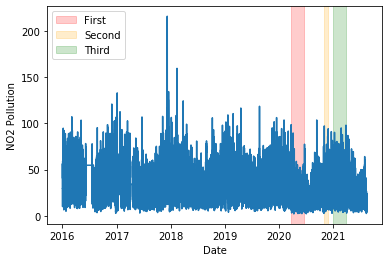

In [15]:
plt.plot(MCC_pollution.date,MCC_pollution.NO2)
plt.axvspan(datetime.datetime(2020, 3, 23), datetime.datetime(2020, 6, 23),0,200, alpha=0.2, color='red',label='First')
plt.axvspan(datetime.datetime(2020, 10, 31), datetime.datetime(2020, 12, 2),0,200, alpha=0.2, color='orange', label = 'Second')
plt.axvspan(datetime.datetime(2021, 1, 6), datetime.datetime(2021, 3, 31),0,200, alpha=0.2, color='green', label = 'Third ')
plt.legend()
plt.ylabel('NO2 Pollution')
plt.xlabel('Date')


In [16]:
#read in traffic data
MCC_frame_traff = pd.read_csv('./traffic_data/pvr_2016-01-01_1597d_portland.csv')
#read in metadata
metadata = pd.read_csv('./traffic_data/GM_JOURNEY_TIME_sites.csv')
MCC_frame_traff['datetime'] = pd.to_datetime(MCC_frame_traff['Sdate'])
MCC_frame_traff = MCC_frame_traff.sort_values(by='datetime',ascending=True)

# #pdb.set_trace()
MCC_frame_traff= MCC_frame_traff.set_index('datetime')

#resample to get houry data
MCC_frame_traff= MCC_frame_traff.resample('60Min').sum()
MCC_frame_traff

,LaneNumber,LaneDirection,Volume,Flags,AvgSpeed,PmlHGV
datetime,,,,,,
2016-03-03 12:00:00,3,4,228,0,0.0,0.0
2016-03-03 13:00:00,3,4,228,0,0.0,0.0
2016-03-03 14:00:00,3,4,200,0,0.0,0.0
2016-03-03 15:00:00,3,4,233,0,0.0,0.0
2016-03-03 16:00:00,3,4,257,0,0.0,0.0
...,...,...,...,...,...,...
2020-05-15 08:00:00,3,4,62,0,0.0,0.0
2020-05-15 09:00:00,3,4,82,0,0.0,0.0
2020-05-15 10:00:00,3,4,80,0,0.0,0.0


In [17]:
# check if MCC _traffic dat has complete timesteps
print(pd.date_range(start= str(MCC_frame_traff.index[0]), end=str(MCC_frame_traff.index[-1]), freq='1H').shape[0]== MCC_frame_traff.shape[0] )

True


In [18]:
#check for NaN values 
for i in MCC_frame_traff.columns:
    print(np.count_nonzero(np.isnan(MCC_frame_traff[i])))

0
0
0
0
0
0


In [19]:
MCC_combined = MCC_pollution.set_index('date').join(MCC_frame_traff,how='inner')
MCC_combined

,O3,NO2,SO2,NOXasNO2,NO,PM2.5,NV2.5,V2.5,temp,ws,...,RAWPM25,Ox,NOx,Lockdown,LaneNumber,LaneDirection,Volume,Flags,AvgSpeed,PmlHGV
2016-03-03 12:00:00,9.47958,73.31378,NaN,151.57901,51.04326,9.800,6.8,3.0,4.9,1.6,...,NaN,82.79336,124.35704,0,3,4,228,0,0.0,0.0
2016-03-03 13:00:00,15.76603,65.91144,NaN,114.62473,31.76998,14.400,8.8,5.6,6.9,3.3,...,NaN,81.67747,97.68142,0,3,4,228,0,0.0,0.0
2016-03-03 14:00:00,29.78582,53.78619,NaN,88.04289,22.34164,8.700,5.3,3.4,7.3,3.4,...,NaN,83.57201,76.12783,0,3,4,200,0,0.0,0.0
2016-03-03 15:00:00,31.18281,52.22177,NaN,78.53920,17.16378,6.000,2.9,3.1,6.2,1.6,...,NaN,83.40458,69.38555,0,3,4,233,0,0.0,0.0
2016-03-03 16:00:00,22.90066,63.48544,NaN,113.13011,32.37741,7.300,4.2,3.1,4.3,1.9,...,NaN,86.38610,95.86285,0,3,4,257,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-15 08:00:00,47.39788,23.82475,1.10006,33.45111,6.27815,5.873,NaN,NaN,7.0,1.4,...,6.225,71.22263,30.10290,1,3,4,62,0,0.0,0.0
2020-05-15 09:00:00,64.96004,11.00070,1.74715,13.91329,1.89954,3.656,NaN,NaN,10.3,2.8,...,3.875,75.96074,12.90024,1,3,4,82,0,0.0,0.0
2020-05-15 10:00:00,69.79961,8.87959,2.91191,11.05170,1.41661,3.915,NaN,NaN,12.4,3.2,...,4.150,78.67920,10.29620,1,3,4,80,0,0.0,0.0
2020-05-15 11:00:00,70.64778,8.97830,3.04133,11.10103,1.38441,3.962,NaN,NaN,13.4,4.4,...,4.200,79.62608,10.36271,1,3,4,38,0,0.0,0.0


In [20]:
#get relevant data
df = MCC_combined[['NO2','temp','ws','wd','Volume','Lockdown']]


df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day

days = pd.DataFrame(pd.get_dummies(df['day_of_week'])).rename(columns={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df = df.merge(days,on=None,left_index=True,right_index=True)


months = pd.DataFrame(pd.get_dummies(df['month'])).rename(columns={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
df = df.merge(months,on=None,left_index=True,right_index=True)


#change wind direction to 4 one-hot-encoded columns 
wind_directions = pd.get_dummies( pd.cut(MCC_combined['wd'].to_numpy(),
                                         bins = [0,90,180,270,360],right=True, 
                                         labels =['wd_1','wd_2','wd_3','wd_4']))

wind_directions = wind_directions.set_index(df.index)


df = df.merge(wind_directions,on=None, left_index=True,right_index=True)




#save to csv
df.to_csv('./MCC_combined.csv', index=True)

/home/elia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/elia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/elia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [21]:
#load data
sharston_pollution = pd.read_csv("./AURN_data_download/Manchester/MAHG.csv",parse_dates =['date'])

In [22]:
#check if sharston data is complete

#shartson data is incomplete
print( pd.date_range(start=str(sharston_pollution.date.to_numpy()[0]), end= str(sharston_pollution.date.to_numpy()[-1]), freq='1H').shape[0] == sharston_pollution.shape[0] ) 

#insert missing timesteps
sharston_pollution = sharston_pollution.resample('1H', on='date').first().drop('date', 1).reset_index()

#shartson data is incomplete

print( pd.date_range(start=str(sharston_pollution.date.to_numpy()[0]), end= str(sharston_pollution.date.to_numpy()[-1]), freq='1H').shape[0] == sharston_pollution.shape[0] )



False
True


In [23]:
# fill in data for temp, ws, wd using data from the previous hour
fill_in(sharston_pollution,'NO2',index=1)
fill_in(sharston_pollution,'temp', index = 1)
fill_in(sharston_pollution,'ws', index = 1)
fill_in(sharston_pollution,'wd', index = 1)

/home/elia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


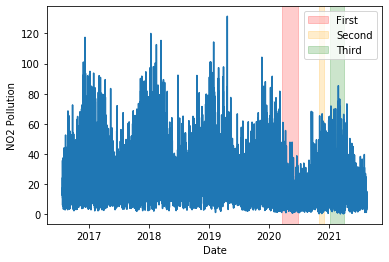

In [24]:
first_lockdown = (sharston_pollution.date>='2020-03-23') & (sharston_pollution.date<='2020-06-23')
second_lockdown = (sharston_pollution.date>='2020-10-31') & (sharston_pollution.date<='2020-12-02')
third_lockdown = (sharston_pollution.date>='2021-01-06') & (sharston_pollution.date<='2021-03-31')
sharston_pollution['Lockdown'] = 0 
sharston_pollution['Lockdown'][first_lockdown | second_lockdown | third_lockdown] = 1

plt.plot(sharston_pollution.date,sharston_pollution.NO2)
plt.axvspan(datetime.datetime(2020, 3, 23), datetime.datetime(2020, 6, 23),0,200, alpha=0.2, color='red',label='First')
plt.axvspan(datetime.datetime(2020, 10, 31), datetime.datetime(2020, 12, 2),0,200, alpha=0.2, color='orange', label = 'Second')
plt.axvspan(datetime.datetime(2021, 1, 6), datetime.datetime(2021, 3, 31),0,200, alpha=0.2, color='green', label = 'Third ')
plt.legend()
plt.ylabel('NO2 Pollution')
plt.xlabel('Date')

sharston_pollution = sharston_pollution.set_index('date')

In [25]:
#traffic data extraction sharston
shar_frame_traff = pd.read_csv('./traffic_data/pvr_2016-01-01_1591d_Sharston.csv')
metadata = pd.read_csv('./traffic_data/GM_JOURNEY_TIME_sites.csv')
shar_frame_traff['datetime'] = pd.to_datetime(shar_frame_traff['Sdate'])
shar_frame_traff = shar_frame_traff.sort_values(by='datetime',ascending=True)
# #pdb.set_trace()
shar_frame_traff= shar_frame_traff.set_index('datetime')
shar_frame_traff= shar_frame_traff.resample('60Min').sum()
shar_frame_traff

,LaneNumber,LaneDirection,Volume,Flags,AvgSpeed,PmlHGV
datetime,,,,,,
2016-01-01 00:00:00,3,4,97,32,0.0,0.0
2016-01-01 01:00:00,3,4,154,32,0.0,0.0
2016-01-01 02:00:00,3,4,106,32,0.0,0.0
2016-01-01 03:00:00,3,4,46,32,0.0,0.0
2016-01-01 04:00:00,3,4,36,32,0.0,0.0
...,...,...,...,...,...,...
2020-05-09 15:00:00,3,4,256,0,0.0,0.0
2020-05-09 16:00:00,3,4,240,0,0.0,0.0
2020-05-09 17:00:00,3,4,230,0,0.0,0.0


In [26]:
#sharston traffic data is complete
print ( pd.date_range(start=str(shar_frame_traff.index[0]), end=str(shar_frame_traff.index[-1]), freq='1H').shape[0] == shar_frame_traff.shape[0] ) 

True


In [27]:
sharston_combined = sharston_pollution.join(shar_frame_traff,how='inner')
sharston_combined.head()

,NO,NO2,O3,NOXasNO2,temp,ws,wd,site,code,latitude,longitude,Ox,NOx,Lockdown,LaneNumber,LaneDirection,Volume,Flags,AvgSpeed,PmlHGV
2016-07-21 00:00:00,1.05605,23.83039,23.54926,25.44964,12.2,2.5,219.3,Manchester Sharston,MAHG,53.371306,-2.239218,47.37965,24.88644,0,3,4,47,0,0.0,0.0
2016-07-21 01:00:00,0.97123,16.47491,21.88618,17.96411,12.3,2.4,220.0,Manchester Sharston,MAHG,53.371306,-2.239218,38.36109,17.44614,0,3,4,26,0,0.0,0.0
2016-07-21 02:00:00,1.04555,17.09345,18.31055,18.69660,12.1,2.9,225.5,Manchester Sharston,MAHG,53.371306,-2.239218,35.40400,18.13900,0,3,4,44,0,0.0,0.0
2016-07-21 03:00:00,1.39386,17.29187,19.35829,19.42909,11.5,2.7,223.2,Manchester Sharston,MAHG,53.371306,-2.239218,36.65016,18.68573,0,3,4,34,0,0.0,0.0
2016-07-21 04:00:00,3.16814,18.67174,12.32345,23.52949,11.2,2.3,209.1,Manchester Sharston,MAHG,53.371306,-2.239218,30.99519,21.83988,0,3,4,50,0,0.0,0.0


In [28]:
#save to csv
df = sharston_combined[['NO2','temp','ws','wd','Volume','Lockdown']]

df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day

days = pd.DataFrame(pd.get_dummies(df['day_of_week'])).rename(columns={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df = df.merge(days,on=None,left_index=True,right_index=True)


months = pd.DataFrame(pd.get_dummies(df['month'])).rename(columns={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
df = df.merge(months,on=None,left_index=True,right_index=True)


#change wind direction to 4 one-hot-encoded columns 
wind_directions = pd.get_dummies( pd.cut(sharston_combined['wd'].to_numpy(),
                                         bins = [0,90,180,270,360],right=True, 
                                         labels =['wd_1','wd_2','wd_3','wd_4']))

wind_directions = wind_directions.set_index(df.index)


df = df.merge(wind_directions,on=None, left_index=True,right_index=True)

df.to_csv('./sharston_combined.csv', index=True)

/home/elia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/elia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/elia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the